# check how the data is structured for fugw

In [1]:
from nilearn import datasets, image, surface
import gdist
import numpy as np

In [2]:
contrasts = [
    "sentence reading vs checkerboard",
    "sentence listening",
    "calculation vs sentences",
    "left vs right button press",
    "checkerboard",
]

n_subjects = 2

brain_data = datasets.fetch_localizer_contrasts(
    contrasts,
    n_subjects=n_subjects,
    get_anats=True,
)

source_imgs_paths = brain_data["cmaps"][0 : len(contrasts)]
target_imgs_paths = brain_data["cmaps"][len(contrasts) : 2 * len(contrasts)]

In [ ]:
fsaverage3 = datasets.fetch_surf_fsaverage(mesh="fsaverage3")

def load_images_and_project_to_surface(image_paths):
    """Util function for loading and projecting volumetric images."""
    images = [image.load_img(img) for img in image_paths]
    surface_images = [
        np.nan_to_num(surface.vol_to_surf(img, fsaverage3.pial_left))
        for img in images
    ]

    return np.stack(surface_images)

source_features = load_images_and_project_to_surface(source_imgs_paths)
target_features = load_images_and_project_to_surface(target_imgs_paths)

In [ ]:
print(target_features.shape)
print(source_features.shape)

(5, 642)
(5, 642)


In [ ]:
fsaverage3 = datasets.fetch_surf_fsaverage(mesh="fsaverage3")

def compute_geometry_from_mesh(mesh_path):
    """Util function to compute matrix of geodesic distances of a mesh."""
    (coordinates, triangles) = surface.load_surf_mesh(mesh_path)
    geometry = gdist.local_gdist_matrix(
        coordinates.astype(np.float64), triangles.astype(np.int32)
    ).toarray()

    return geometry


fsaverage3_pial_left_geometry = compute_geometry_from_mesh(
    fsaverage3.pial_left
)
source_geometry = fsaverage3_pial_left_geometry
target_geometry = fsaverage3_pial_left_geometry

# load our data

In [4]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

base_dir = os.path.abspath('..')
sys.path.append(base_dir)

from graph_matching.data_loader.graph_loader import NetworkLoader
from graph_matching.data_loader.graph_loader import compute_mean_network

atlas = 'Schaefer1000'
structure_type='ses-01'
loader = NetworkLoader(atlas, structure_type, base_dir=base_dir+'/data_new_struct')

In [5]:
_, network, atlas_coord = next(loader)
atlas_coord = atlas_coord.transpose()
network = network.astype(float)

In [6]:
mean_network, mean_network_atlas_coord = compute_mean_network(loader)

In [7]:
### check that dim and dtypes are the same 
# features correspond to out atlas
print(source_features.shape)
print(source_features.dtype)

print(atlas_coord.shape)
print(atlas_coord.dtype)

# geometry corresponds to our network
print(source_geometry.shape)
print(source_geometry.dtype)

print(network.shape)
print(network.dtype)

NameError: name 'source_features' is not defined

In [8]:
### Normalize
atlas_coord_normalized = atlas_coord / np.linalg.norm(
    atlas_coord, axis=1
).reshape(-1, 1)
network_normalized = network / np.max(network)
mean_network_normalized = mean_network / np.max(mean_network)

In [9]:
from fugw.mappings import FUGW
alpha = 0.5
rho = 1
eps = 1e-5
mapping = FUGW(alpha=alpha, rho=rho, eps=eps)

In [ ]:
_ = mapping.fit(
    atlas_coord_normalized,
    atlas_coord_normalized,
    source_geometry=network_normalized,
    target_geometry=mean_network_normalized,
    solver="sinkhorn",
    solver_params={
        "nits_bcd": 5,
        "tol_bcd": 1e-10,
        "tol_uot": 1e-10,
    },
    verbose=False,
)

/opt/anaconda3/envs/graph_matching/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install "ipywidgets"
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [ ]:
mapping.pi

tensor([[5.6765e-04, 1.5046e-04, 4.1395e-05,  ..., 1.6510e-41, 0.0000e+00,
         0.0000e+00],
        [1.7195e-04, 5.9058e-04, 6.9621e-05,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.6395e-05, 6.8109e-05, 5.8873e-04,  ..., 5.8855e-43, 0.0000e+00,
         0.0000e+00],
        ...,
        [3.8815e-41, 0.0000e+00, 1.2331e-42,  ..., 2.9335e-04, 6.1506e-05,
         8.7690e-06],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 5.6022e-05, 2.6470e-04,
         1.0962e-04],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 9.1323e-06, 1.0543e-04,
         2.2142e-04]])

In [ ]:
print(mapping.pi.sum())
print(mapping.pi.trace())

tensor(1.0000)
tensor(0.5818)


/var/folders/y6/j9fbqcvx6lb5l99614n30y4c0000gn/T/ipykernel_3766/3714950224.py:6: RuntimeWarning: divide by zero encountered in log
  im = plt.imshow(np.log(pi), cmap="magma")


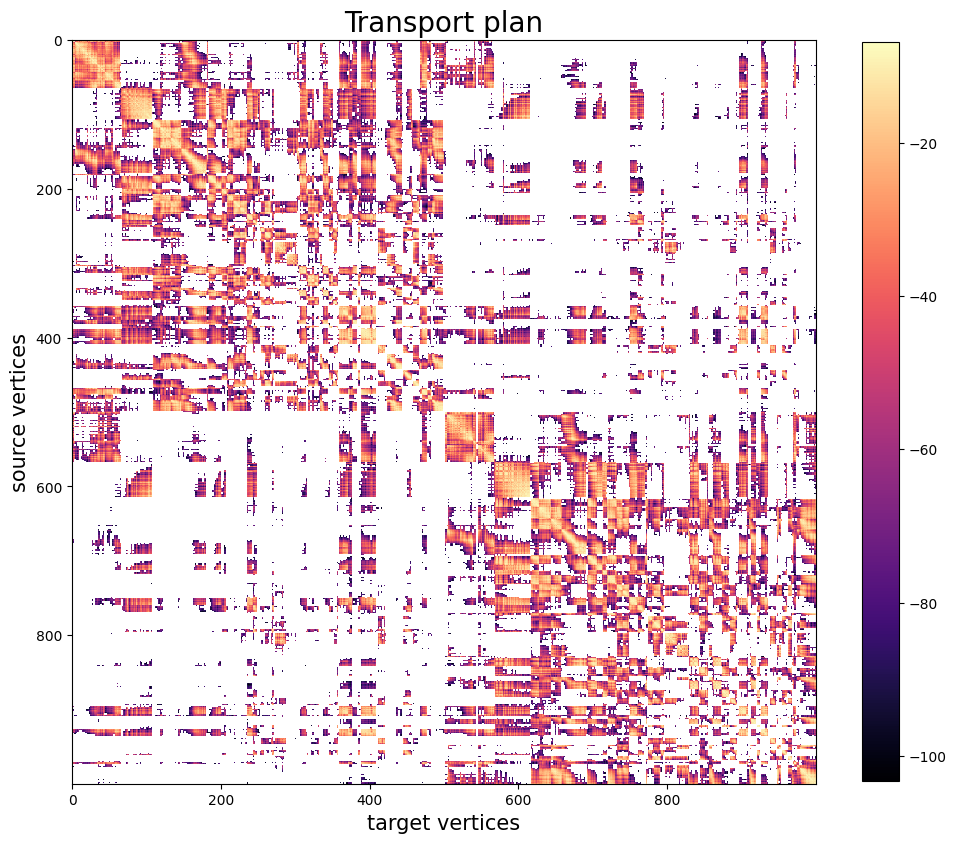

In [ ]:
pi = mapping.pi.numpy()
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_title("Transport plan", fontsize=20)
ax.set_xlabel("target vertices", fontsize=15)
ax.set_ylabel("source vertices", fontsize=15)
im = plt.imshow(np.log(pi), cmap="magma")
#im = plt.imshow(pi, cmap="magma")
plt.colorbar(im, ax=ax, shrink=0.8)
plt.show()

In [ ]:
import tensorflow as tf
import bvn

ImportError: cannot import name 'from_numpy_matrix' from 'networkx' (/opt/anaconda3/envs/graph_matching/lib/python3.11/site-packages/networkx/__init__.py)

In [ ]:
mapping.pi

In [ ]:
pi_tf = tf.convert_to_tensor(mapping.pi.numpy(), np.float32)

[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), (10, 11, 12, 13, 14, 15, 16, 17, 18, 19)]

In [ ]:
p, c = bvn.bvn(pi_tf, 100)

#def sample_permutation_matrix(A, num_samples):
#    [permutation_matrices, weights] = list(zip(*birkhoff_von_neumann_decomposition(A)))
#    cdf = np.cumsum(weights)
#
#    samples = []
#    for _ in range(num_samples):
#        r = np.random.rand()
#        k = np.searchsorted(cdf, r)
#        samples.append(permutation_matrices[k])
#
#    return samples